In [246]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 

import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj


%matplotlib inline
%load_ext autoreload
%autoreload 2

dtype = torch.float
device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
# generell parameters
number_nei = 7
step_nr = 1

In [248]:
FPS = 16

PATH = "data/converted/"
PATH2 = "data/CSV/"
fname = "ao-360-400_combine"

#PATH_1 = "test.hd5"
#PATH_1 = "test.csv"

#ds = DataLoader(PATH + fname + ".txt")
ds = DataLoader(PATH2 + fname + ".csv")
ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )



Persons:  350
Frame maximum : 821


In [249]:
#for i in range(20, 351):
#    ds.remove_person(i)

#ds.save("data/CSV/" + fname + "_tiny")

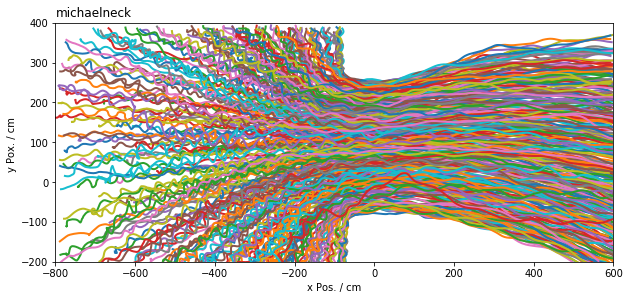

In [250]:
plotTraj(ds, boundaries=[-800, 600, -200, 400], title="michaelneck", save=False)

In [244]:
animatePreview(ds, boundaries=[-800, 600, -200, 400], step=10)

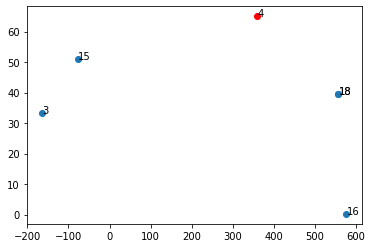

In [40]:
pids, pvals = ds.frame_nn(f_id = 340, p_id=4, nn=number_nei, ret_vel=False, fill=True, mode="wrap", use_roi=False, 
              include_origin=True, ret_full=False, box=((-800, -200), (600,400)), x_pad=0, y_pad=0)

plt.figure()
plt.scatter(pvals[0,0], pvals[0,1], color="red")
plt.scatter(pvals[1:,0], pvals[1:,1])

for (i, xy) in zip(pids, pvals):
    plt.annotate("{}".format(i), xy=xy)
plt.show()

In [11]:
#train_id, trajectories = ds.get_trajectories(number_nei, ret_vel=True, fill=True, mode="zero", omit_no_neighbors=False, 
#                                             use_roi=False, box=((-800, 400), (600,-200)), x_pad=0, y_pad=0,)

In [251]:
#f_x = ds.flip_x
train, val, test = ds.get_train_data(number_nei, step_nr=step_nr, shuffle=False, mode="wrap", split=(100,0,0))

100% (350 of 350) |######################| Elapsed Time: 0:02:32 Time:  0:02:32


loaded 350 trajectories
with augmentation 350 trajectories
extracted 106443 steps


In [252]:
t_input, t_truth = train

In [253]:
t_i = torch.from_numpy(t_input).to(device)
t_t = torch.from_numpy(t_truth).to(device)

(11280, 96)

# Define Model

In [270]:
# Hyper-parameters 

batch_size = 1

input_size = (number_nei+1)*4*step_nr
hidden_size = 1000
output_size = 2
num_epochs = 1
learning_rate = 1e-4


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, output_size).to(device)

In [271]:
#loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [272]:
def batch(arr1, arr2, n):
    """Yield successive n-sized chunks from l."""
    size = len(arr1)
    for i in range(0, size, n):
        yield arr1[i:min(i + n, size)], arr2[i:min(i + n, size)]

# Train the model
pbar = progressbar.ProgressBar(maxval=np.ceil(len(t_i)/float(batch_size))*num_epochs)
pbar.start()
i = 0
for epoch in range(num_epochs):
    for (ti, tt) in batch(t_i, t_t, batch_size):
        # Forward pass
        pred = model(ti)
        loss = loss_fn(pred, tt)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%10:
            pbar.update(i)
        i += 1

pbar.finish()

100% (106443.0 of 106443.0) |############| Elapsed Time: 0:02:40 Time:  0:02:40


In [273]:
# save the model
file = "360"
people = "all"

torch.save(model.state_dict(), "data/model/model_{}_{}_{}_{}_{}.dat".format(file, people, number_nei, step_nr, num_epochs))

In [184]:
model2 = NeuralNet(input_size, hidden_size, output_size).to(device)
model2.load_state_dict(torch.load("data/model/model_360_1to50_2_1.dat"))
model2.eval()

NeuralNet(
  (fc1): Linear(in_features=24, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)

['p', 'f', 'y', 'x', 'z', 'vx', 'vy']

# Simulate 1 Trajectory

In [296]:
da = DataLoader(None)
da.copy(ds)

print(da.persons)

350


In [297]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
import pandas as pd

id = 33
frames, traj = da.person(id)
frame0 = frames[0]

steps = da.data['f'].max() - da.data['f'].min()
steps = 300

with torch.no_grad():
    for i in range(steps-step_nr):
        if step_nr == 1:
            inp = da.frame_nn(frame0+i, id, number_nei, mode="wrap", use_roi=False)[1].ravel()
        else:
            temp = []
            for j in range(step_nr):
                temp.append(da.frame_nn(frame0 + i + j, id, number_nei, mode="wrap", use_roi=False)[1])
            
            inp = np.vstack(temp).ravel()
        
        inp = inp.astype(np.float32)
        x_sim = torch.from_numpy(inp).to(device)
        y_sim = model(x_sim)

        v_sim = (y_sim[:2]-x_sim[:2])/FPS
        pos = y_sim.cpu().detach().numpy()
        vel = v_sim.cpu().detach().numpy()
        
        entry = np.concatenate(([id], [frame0 + i + 1], np.flip(pos), [0], vel))
        
        if len(da.data[(da.data["p"]==id) & (da.data["f"]==frame0 + i + 1)]):
            da.data[(da.data['p']==id) & (da.data['f']==frame0 + i + 1)] = [entry]
        else:
            da.data = da.data.append(pd.DataFrame([entry], columns=list(da.data)), ignore_index=True)     

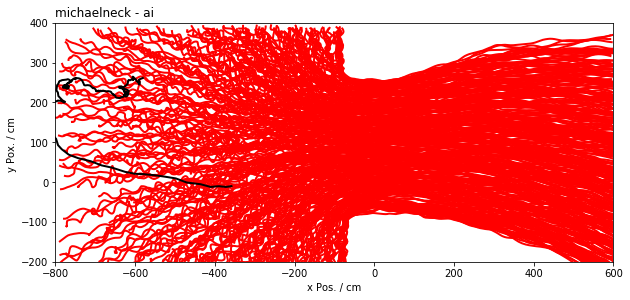

In [298]:
plotTraj(da, boundaries=[-800, 600, -200, 400], ai = [id], title="michaelneck - ai", save=False)

In [295]:
animatePreview(da, boundaries=[-800, 600, -200, 400], step=10)

In [302]:
ani = animateLoc(da, frame_start=30, frame_stop=330, ai=[id], 
                 boundaries=[-800, 600, -200, 400], step=1, fps=16, title="michaelneck", save=False)
ani

# Simulate All Trajectories

In [22]:
db = DataLoader(None)
pers, init_val = ds.frame(30)
frames = np.arange(30,100)

for (p_id, init) in zip(pers, init_val):
    pos = init[:2]
    vel = init[2:]
    db.append_person(id=p_id, frame=np.array([30]), traj=np.array([pos]), vel=np.array([vel]))

In [23]:
with torch.no_grad():
    pbar = progressbar.ProgressBar(maxval=len(frames))
    pbar.start()
    for i, frame in enumerate(frames):
        pbar.update(i)
        for per in pers:
            _, _, traj, _ = db.frame_nn(frame, per, number_nei, ret_vel=True, fill=True, mode="zero", use_roi=False, 
                                        ret_full=True, include_origin=True, box=((-800, 400), (600,-200)), x_pad=0, y_pad=0,)
            traj = traj.ravel().astype(np.float32)
            x_sim = torch.from_numpy(traj).to(device)
            y_sim = model(x_sim)

            v_sim = (y_sim[:2]-x_sim[:2])/FPS
            out = np.zeros(4)
            out[:2] = y_sim.cpu().detach().numpy()
            out[2:4] = v_sim.cpu().detach().numpy()

            frames, trajs =db.person(per) 
            db.replace_person(per, np.append(frames, frame+1),  np.append(trajs[:,:2], out[:2].reshape(1,2), axis=0), np.append(trajs[:,2:], out[2:4].reshape(1,2), axis=0))
            
    pbar.finish()   

100% (70 of 70) |########################| Elapsed Time: 0:05:55 Time:  0:05:55


In [156]:
animatePreview(da, boundaries=[-800, 600, -200, 400], step=1)

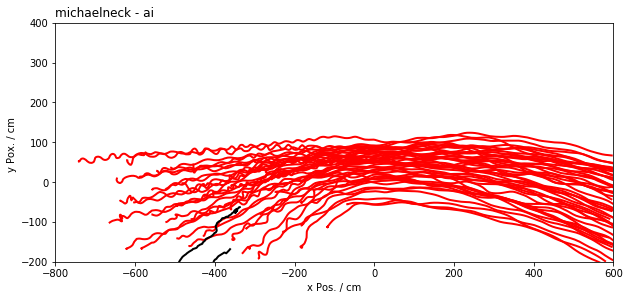

In [206]:
plotTraj(da, boundaries=[-800, 600, -200, 400], ai = [id], title="michaelneck - ai", save=False)

In [28]:
ani = animateLoc(db, frame_start=30, frame_stop=100, ai=None, 
                 boundaries=[-800, 600, -200, 400], step=5, fps=16, title="michaelneck", save=False)
ani

In [105]:
da.data['f'].min()

14.0